In [1]:
import numpy as np
import tensorrt
import tensorflow as tf
import keras
from keras import layers
from keras import backend

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

2023-10-23 12:07:10.205842: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-23 12:07:10.243592: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Create test model

In [2]:
def masked_MeanSquaredError(y_true, y_pred, mask):
    mse = tf.keras.losses.MeanSquaredError()
    return mse(y_true * mask, y_pred * mask)

class MaskModel(keras.Model):
  def __init__(self):
    super().__init__()
    self.conv1 = layers.Conv1D(32, 2, activation='relu')
    self.flatten = layers.Flatten()
    self.d1 = layers.Dense(12, activation='relu')
    self.d2 = layers.Dense(2500)

    self.loss_mse = tf.keras.losses.MeanSquaredError()
    self.loss_masked_mse= masked_MeanSquaredError
    self.optimizer = tf.keras.optimizers.SGD()
    self.train_loss = tf.keras.metrics.Mean(name='train_loss')
    self.train_accuracy = tf.keras.metrics.MeanSquaredError(name='train_accuracy')



  def call(self, x):
    x = self.conv1(x)
    x = self.flatten(x)
    x = self.d1(x)
    x = self.d2(x)
    return tf.reshape(x, (-1,50,50))
  
  def train_step(self, data):
    seqs, labels, masks = data

    with tf.GradientTape() as tape:
      # training=True is only needed if there are layers with different
      # behavior during training versus inference (e.g. Dropout).
      predictions = self(seqs, training=True)
      loss1 = self.loss_mse(labels, predictions)
      loss2 = self.loss_masked_mse(labels, predictions, masks)

    gradients = tape.gradient(loss2, self.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))


In [3]:
# Create an instance of the model
model = MaskModel()

loss_mse = tf.keras.losses.MeanSquaredError()
loss_masked_mse= masked_MeanSquaredError

optimizer = tf.keras.optimizers.SGD()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.MeanSquaredError(name='train_accuracy')

@tf.function
def train_step(seqs, labels, masks):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(seqs, training=True)
    loss1 = loss_mse(labels, predictions)
    loss2 = loss_masked_mse(labels, predictions, masks)

    tf.print('loss_mse: ', loss1)
    tf.print('loss_masked_mse: ', loss2)
    tf.print('---')

    gradients = tape.gradient(loss2, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  # train_loss(loss)
  # train_accuracy(labels, predictions)

2023-10-23 12:07:18.807197: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-10-23 12:07:18.807335: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: b17-05.hpc.usc.edu
2023-10-23 12:07:18.807348: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: b17-05.hpc.usc.edu
2023-10-23 12:07:18.807432: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 510.73.8
2023-10-23 12:07:18.807529: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 510.73.8
2023-10-23 12:07:18.807538: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 510.73.8


# Read Data

In [9]:
def file_to_records(filename):
  return tf.data.TFRecordDataset(filename, compression_type='ZLIB')

In [10]:
# seq_depth = 4 here, as four nucleotides
def parse_proto(example_protos, seq_length=25000, seq_depth=4, target_length=50, num_targets=50):
      """Parse TFRecord protobuf."""

      # define features
      features = {
        'sequence': tf.io.FixedLenFeature([], tf.string),
        'target': tf.io.FixedLenFeature([], tf.string),
        'mask': tf.io.FixedLenFeature([], tf.string)
      }

      # parse example into features
      parsed_features = tf.io.parse_single_example(example_protos, features=features)

      # decode sequence
      sequence = tf.io.decode_raw(parsed_features['sequence'], tf.uint8)
      sequence = tf.reshape(sequence, [seq_length, seq_depth])
    #     if self.seq_length_crop is not None:
    #       crop_len = (self.seq_length - self.seq_length_crop) // 2
    #       sequence = sequence[crop_len:-crop_len,:]
      sequence = tf.cast(sequence, tf.float32)
        
      # decode targets
      targets = tf.io.decode_raw(parsed_features['target'], tf.float16)
      targets = tf.reshape(targets, [target_length, num_targets])
      targets = tf.cast(targets, tf.float32)

      #decode mask
      mask = tf.io.decode_raw(parsed_features['mask'], tf.float16)
      mask = tf.reshape(mask, [target_length, num_targets])
      mask = tf.cast(mask, tf.float32)

      return sequence, targets, mask


In [11]:
tfr_path = '/home1/yxiao977/sc1/akita_dinoflagellate/squares_train_test_mask/*'
# ds = tf.data.TFRecordDataset(tfr_path, compression_type='ZLIB')

In [12]:
import glob
from natsort import natsorted
tfr_files = natsorted(glob.glob(tfr_path))
dataset = tf.data.Dataset.from_tensor_slices(tfr_files[:2])

# repeat, so iteration on the dataset can be infinite untill you call stop
# dataset = dataset.repeat()

# interleave files
dataset = dataset.interleave(map_func=file_to_records,
    cycle_length=4,
    num_parallel_calls=tf.data.experimental.AUTOTUNE)

# shuffle
dataset = dataset.shuffle(buffer_size=128, reshuffle_each_iteration=True)

dataset = dataset.map(parse_proto) #self.rna_mode

# batch
dataset = dataset.batch(32)

# prefetch
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [13]:
tf.keras.utils.set_random_seed(9)

EPOCHS = 1
# train_ds = [(sequence, target)]
for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()

  for seqs, labels, masks in dataset:
    train_step(seqs, labels, masks)

  # for test_images, test_labels in test_ds:
  #   test_step(test_images, test_labels)

  # print(
  #   f'Epoch {epoch + 1}, '
  #   f'Loss: {train_loss.result()}, '
  #   f'Accuracy: {train_accuracy.result() * 100}, '
  #   f'Test Loss: {test_loss.result()}, '
  #   f'Test Accuracy: {test_accuracy.result() * 100}'
  # )


loss_mse:  0.250620306
loss_masked_mse:  0.212336317
---


loss_mse:  0.257475674
loss_masked_mse:  0.216389656
---


In [14]:
test_pred = model(seqs, training=False)

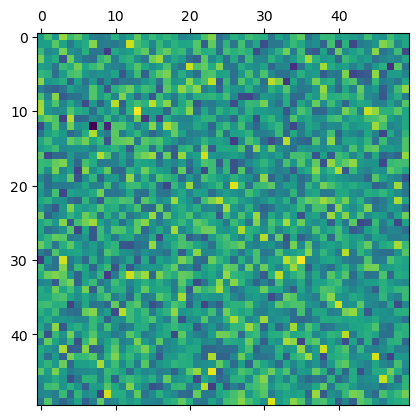

In [16]:
from matplotlib import pyplot as plt
plt.matshow(test_pred[0])

# Plot loss during training

In [ ]:
import numpy as np 
from tensorflow import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output

class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

# Simulation test

In [7]:
for d in ds.take(1):
      t = parse_proto(d)

In [ ]:
target_obs = target.copy()
num_missing_bins = np.random.randint(10)
id_missing_bins = #choose num_missing_bins
target_obs[id_missing_bins, :] = np.nan
target_obs[:,id_missing_bins] = np.nan

In [ ]:
def get_mask(mymap):
    return mask


tf.mse(target, prediction)-->  my_masked_loss(target_obs,prediction, mask )




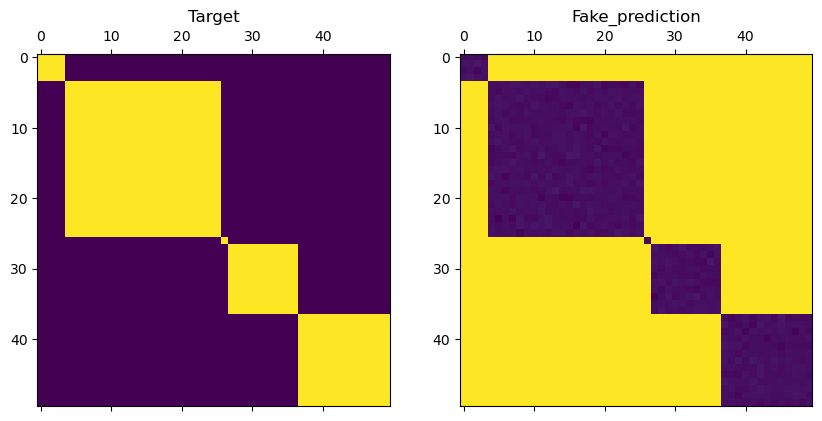

In [9]:
from matplotlib import pyplot as plt
sequence = tf.cast(t[0], tf.float32)
sequence = sequence[tf.newaxis,...]
target = t[1].numpy()
# target[20:25] = np.nan
# target[:, 20:25] = np.nan
target = tf.cast(target, tf.float32)

fake_prediction = np.random.normal(loc=50, scale=100,size=(50, 50))
mask = (target == 0)
fake_prediction[mask] = 9999

f, axes = plt.subplots(1, 2)
axes[0].matshow(target)
axes[0].title.set_text('Target')
axes[1].matshow(fake_prediction)
axes[1].title.set_text('Fake_prediction')
f.set_size_inches(10, 5)

In [10]:
loss_object1 = tf.keras.losses.MeanSquaredError()

print('unmasked loss: ', loss_object1(target, fake_prediction).numpy())
print('masked loss: ', loss_object1(target[~mask], fake_prediction[~mask]).numpy())

unmasked loss:  69190227.3526252
masked loss:  13203.443588376193
